# DOMAĆI ZADATAK:

## Mihajlo Ivković, RA39/2022;
## Srđan Slokar, RA149/2022;
## Nađa Tegeltija, RA164/2022;
## Konstantin Malešević, RA166/2022.
### U prilogu je iskorišćen kod sa repozitorijuma:
 https://github.com/rapaja/rl_playground/blob/main/notebooks/SLAA/Maze.ipynb
 zarad najlakšeg načina sporazumevanja. **Rešenje** se nalazi ispod sekcije *Assignments for Individual Work*.

# Maze Solver

A **maze** is a rectangular array of cells. The **agent** may move across the cells of the mase. By stepping into a cell, the agent receives a reward (or pays a penalty). Some cells are **terminal**, when stepping into a terminal cell the agent finishes the game (exits the maze). The **goal** of the agent is to maximize the total cummulative reward (minimize the total cummulative loss).

In addition to **regular** and **terminal** cells, there are also **walls**: walls are forbidden areas of the maze. The agent canot step onto a wall cell.

<div class="alert alert-block alert-info">
<b>The Assignment:</b> 
Implement the maze environment and develop optimal decision policy for moving across the maze.
</div>

## Basic Imports

In [2]:
from abc import ABC, abstractmethod
from typing import Iterable, Callable, final
from copy import copy

import numpy as np
import matplotlib.pyplot as plt

from random import random, choices

/home/konstantin/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## The Maze

Let us implement the maze first, so that later we can implement solution algorithm(s).

We will start by implementing individual cells, and the we will collect them all within a single maze board.

### Implementing Individual Cells

In [3]:
class Cell(ABC):
    """Abstract base class for all maze cells."""

    @abstractmethod
    def get_reward(self) -> float:
        """The reward an agent receives when stepping onto this cell."""
        pass

    def is_steppable(self) -> bool:
        """Checks if an agent can step onto this cell.

        Regular and terminal cells are steppable.
        Walls are not steppable.
        """
        return True

    def is_terminal(self) -> bool:
        """Checks if the cell is terminal.

        When stepping onto a terminal cell the agent exits
        the maze and finishes the game.
        """
        return False

    def has_value(self) -> bool:
        """Check if the cell has value.
        
        The value is defined for regular cells and terminal cells,
        but not for walls. 
        """
        return True

We will use the `Cell` class to derive all other cell classes. Please note that it may seem that `is_steppable` and `has_value` are essentially synonims, but this is not true in general.

Consider for example **teleport cells**. When stepping onto such a cell the agent is instantinuously transported into another, linked cell. Such a cell is different from the cell to which it is linked. It has a distinct geometrical location, and is steppable. However, from routing point of view it is just an alias for the linked cell, and so there is no reason for it to have a distinct value.

Let us now implement some basic types of cells:

In [4]:
class RegularCell(Cell):
    """A common, non-terminal, steppable cell."""

    def __init__(self, reward: float):
        self.reward = reward

    def get_reward(self) -> float:
        return self.reward


class TerminalCell(Cell):
    """A terminal cell."""

    def __init__(self, reward: float):
        self.reward = reward

    def get_reward(self) -> float:
        return self.reward

    def is_terminal(self) -> bool:
        return True

    def has_value(self) -> bool:
        return False


class WallCell(Cell):
    """A non-steppable cell."""

    def get_reward(self) -> float:
        return 0

    def is_steppable(self) -> bool:
        return False

    def has_value(self) -> bool:
        return False

### Implementing the Maze Board

The maze board is essentially a rectangular grid of cells. The board is not concerned with the type of individual cells, it is only interested in their relative arrangement.

In [5]:
class MazeBoard:
    """Rectangular grid of cells representing a single mase."""

    @staticmethod
    def validate_cells(cells: Iterable[Iterable[Cell]]) -> tuple[int, int, list[list[Cell]]]:
        """
        Utility function used to validate the given double-iterable of of cells.
        
        Returns: tuple[int, int, list[list[Cell]]]
            int: number of rows
            int: number of columns
            list[list[Cell]]: double-list of cells from the input iterable
        """
        cells = [list(row) for row in cells] if cells else []
        if not cells:
            raise Exception("Number of rows in a board must be at least one.")
        if not cells[0]:
            raise Exception("There has to be at least one column.")
        rows_no = len(cells)
        cols_no = len(cells[0])
        for row in cells:
            if not row or len(row) != cols_no:
                raise Exception(
                    "Each row in a a board must have the same number of columns. ")
        return rows_no, cols_no, cells
    
    def __init__(self, cells: Iterable[Iterable[Cell]]):
        """
        Initialize the maze board from the given `cells`.

        The input double-iterable of cells is such that the elements of the outer
        iterable are considered to be rows. The input cells must satisfy certain
        conditions in order to be considered valid:

        * There must be at least one row.
        * All rows must be of the same length, which is at least one.
        """
        rows_no, cols_no, cells = MazeBoard.validate_cells(cells)
        self.cells = cells
        self.rows_no = rows_no
        self.cols_no = cols_no

    def __getitem__(self, key: tuple[int, int]) -> Cell:
        """Return cell in the given row and column."""
        r, c = key
        return self.cells[r][c]


### Creating and Visualizing Maze Boards

It would be nice to be able to randomly generate maze boards, and also to visualize them. It will enable us to effectively test our algorithms.

Let us first create a method for randomly generating boards. We will define this method to be very generic, allowing for different kind of cells to be generated with different probability.

In [6]:
# Type-hint used to indicate a function which, when invoked, generates a cell.
CellGenerator = Callable[[], Cell]

def create_random_board(size: tuple[int, int], specs=list[tuple[float, CellGenerator]]) -> MazeBoard:
    """
    Generate a random cell.

    Args:
        size (float): Board size: height and width.
        specs (list[tuple[float, CellGenerator]]):
            List of tuples, each of which contains a weight factor and a Cell-generating function
            The weight-factor is proportional to the probability with thich the Cell-generator
            function will be invoked.
    """
    h, w = size
    weights = [w for w, _ in specs]
    generators = [g for _, g in specs]
    # The line below is a bit tricky...
    # `random_cell` is a function which returns a random cell once it has been invoked.
    # `choices` function returns a list of elements taken from `generators` with probabilities
    #    proportional to `weights`. The length of such list is set to 1. Therefore by indexing
    #    with `[0]` we are actually requiesting for the first and only element of that list.
    # In this way we obtained one such randomly selected generator.
    # We need to invoke it with `()` in order to actually get a cell.
    random_cell = lambda: choices(generators, weights, k=1)[0]()
    cells = [[random_cell() for i in range(w)] for j in range(h)]
    return MazeBoard(cells)

Let us furhter define a function that will help us visualize maze boards.

In [7]:
def default_cell_color(cell: Cell) -> tuple[int, int, int]:
    if isinstance(cell, RegularCell): 
        if cell.get_reward() == -1:
            return (255, 255, 255) # Regular cell
        else:
            return (255, 0, 0) # Regular cell with penalty
    elif isinstance(cell, WallCell):
        return (0, 0, 0) # Wall cell
    else:
        return (0, 0, 255) # Terminal cell

def draw_board(board: MazeBoard, color = default_cell_color, pos: tuple[int, int] = None, ax=None):
    ax = ax if ax is not None else plt
    board_img = np.ones(shape=(board.rows_no, board.cols_no, 3), dtype=np.uint8)
    for i in range(board.rows_no):
        for j in range(board.cols_no):
            board_img[i, j, :] = color(board[i, j])
    if pos is not None:
        row, col = pos
        ax.text(col-0.1, row+0.1, "X", fontweight="bold")
    if ax is not None:
        ax.imshow(board_img)
    else:
        plt.imshow(board_img)

### Testing Maze Board Generation and Visualization

In [11]:
# This will be used as the default specification for the generator...
# It requires that the reqular cells with reward -1 are 7 times more likely than
# regular cells with higher penalty, walls and terminal cells.

DEFAULT_SPECS = [
    (10, lambda: RegularCell(-1)), 
    (2, lambda: RegularCell(-10)),
    (2, lambda: WallCell()),
    (1, lambda: TerminalCell(-1))
]

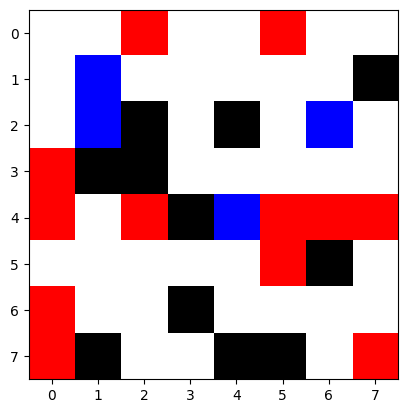

In [81]:
board = create_random_board(size=(8, 8), specs=DEFAULT_SPECS)
draw_board(board)

### Maze as an MDP Environment

We will now wrap the maze board within a MDP environment which we will be used within our Dynamic Programming procedure.

In [13]:
# Let us first enumerate the possible actions for better readability.
RIGHT = 0
UP = 1
LEFT = 2
DOWN = 3

# The following lus is used only to provide human-readable form of each action
ACTIONS = ["RIGHT", "UP", "LEFT", "DOWN"]

In [78]:
class MazeEnvironment:
    """Wrapper for a maze board that behaves like an MDP environment.
    
    This is a callable object that behaves like a deterministic MDP state
    transition function: given the current state and action, it returns the
    following state and reward.

    In addition, the environment object is capable of enumerating all possible
    states and all possible actions. For a given state it is also capable of
    deciding if the state is terminal or not.
    """

    def __init__(self, board: MazeBoard):
        """Initialize the enviornment by specifying the underlying maze board."""
        self.board = board

    def validate_position(self, row, col):
        """A utility function that validates a position."""
        if row < 0 or row >= self.rows_no:
            raise Exception("Invalid row position.")
        if col < 0 or col >= self.cols_no:
            raise Exception("Invalid column position.")
        if not self.board[row, col].is_steppable():
            raise Exception("Invalid position: unsteppable cell.")
        return r, c

    def move_up_from(self, row: int, col: int) -> tuple[int, int]:
        if row != 0 and self.board[row-1, col].is_steppable():
            return row-1, col
        else:
            return row, col

    def move_down_from(self, row: int, col: int) -> tuple[int, int]:
        if row != self.board.rows_no-1 and self.board[row+1, col].is_steppable():
            return row+1, col
        else:
            return row, col

    def move_left_from(self, row: int, col: int) -> tuple[int, int]:
        if col != 0 and self.board[row, col-1].is_steppable():
            return row, col-1
        else:
            return row, col

    def move_right_from(self, row: int, col: int) -> tuple[int, int]:
        if col != self.board.cols_no-1 and self.board[row, col+1].is_steppable():
            return row, col+1
        else:
            return row, col

    def move_from(self, row: int, col: int, action: int) -> tuple[int, int]:
        if action == RIGHT:
            return self.move_right_from(row, col)
        elif action == UP:
            return self.move_up_from(row, col)
        elif action == LEFT:
            return self.move_left_from(row, col)
        elif action == DOWN:
            return self.move_down_from(row, col)
        else:
            raise Exception("Invalid direction.")

    def __call__(self, state: tuple[int, int], action: int) -> tuple[tuple[int, int], float, bool]:
        row, col = state
        new_row, new_col = self.move_from(row, col, action)
        new_cell = self.board[new_row, new_col]
        reward = new_cell.get_reward()
        is_terminal = new_cell.is_terminal()
        return (new_row, new_col), reward, is_terminal

    def get_states(self):
        states = []
        for r in range(self.board.rows_no):
            for c in range(self.board.cols_no):
                if self.board[r, c].is_steppable():
                    states.append((r, c))
        return states

    def is_terminal(self, s):
        return self.board[s[0], s[1]].is_terminal()

    def get_actions(self):
        return [RIGHT, UP, LEFT, DOWN]

Let us test the MDP environment. This will also enable us to understand better the manner in which the environment object is intended to be used.

### Testing the Maze Environment

Let us test the environment by issuing several commands and observing the result.

In [82]:
env = MazeEnvironment(board)

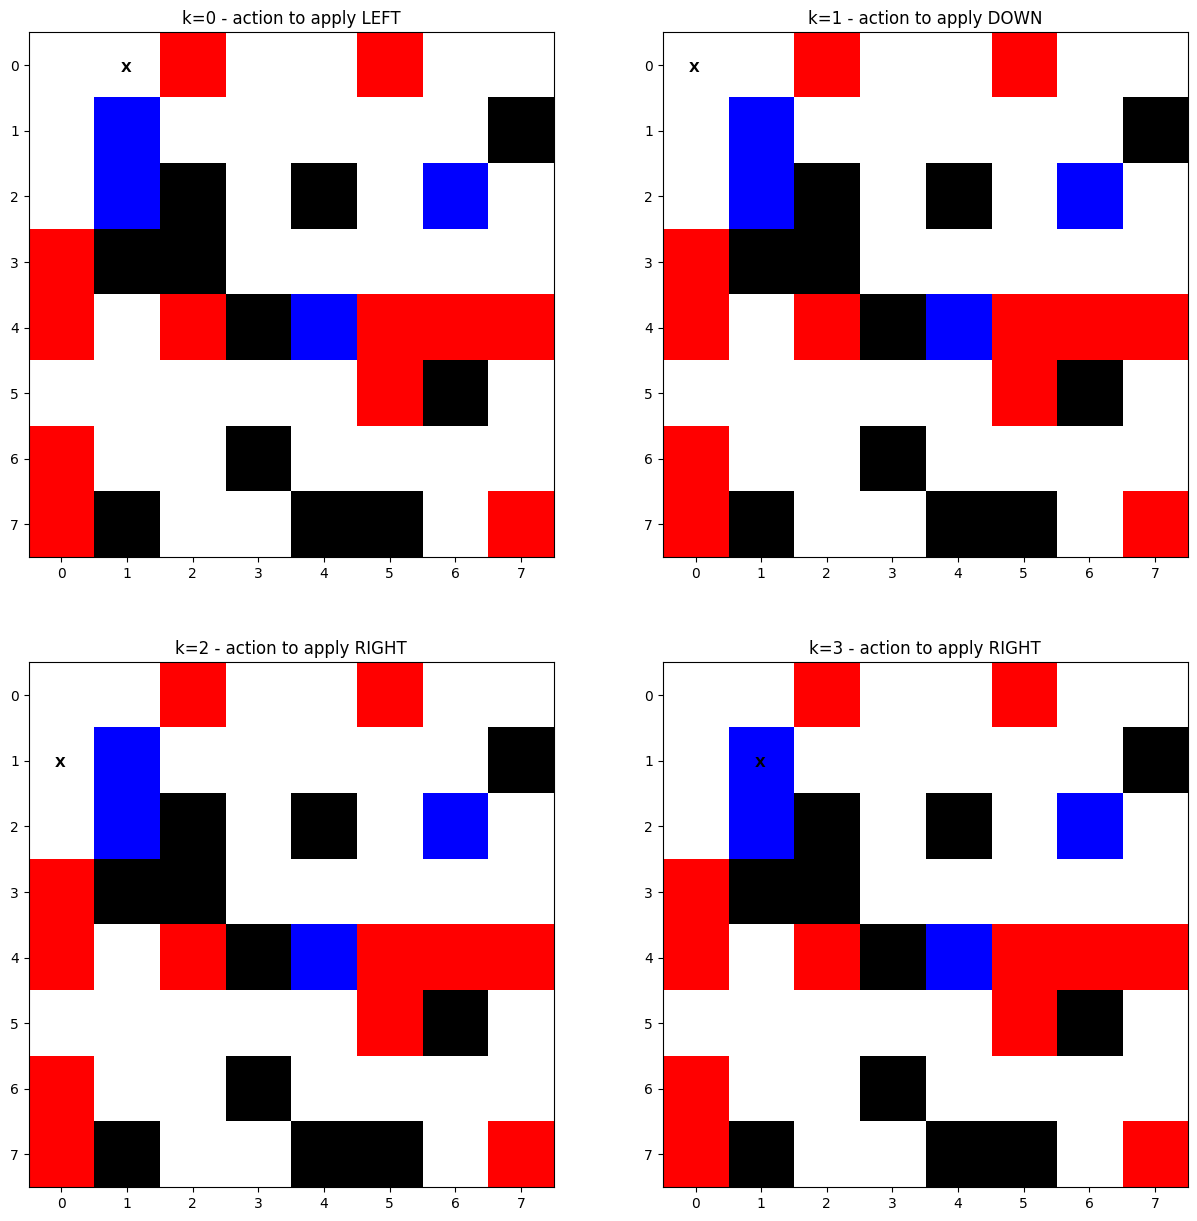

In [83]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
axes = axes.flatten()
axes
state = (0, 1)
actions = [LEFT, DOWN, RIGHT, RIGHT]
for k, (a, ax) in enumerate(zip(actions, axes)):
    ax.set_title(f"k={k} - action to apply {ACTIONS[a]}")
    draw_board(board, pos=state, ax=ax)
    state, reward, terminal = env(state, a)

## Value Iteration Algorithm

Let us now implement the **asynchronous version** of the **VALUE ITERATION ALGORITHM**. This algorithm will enable us to compute optimal state values for each state.

In [51]:
def update_state_value(env: MazeEnvironment, s, v, gamma):
    """Update value of the given state.
    
    Args:
        env (MazeEnvironment): The environment to work on.
        s : The state (cell position).
        v : Values of other states.
        gamma : discount factor.
    """
    rhs = []
    for a in env.get_actions():
        s_new, r, _ = env(s, a)
        rhs.append(r + gamma*v[s_new])
    return max(rhs)

In [52]:
def async_update_all_values(env: MazeEnvironment, v, gamma):
    """Update values of all states.
    
    Args:
        env (MazeEnvironment): The environment to work on.
        v : Values of other states.
        gamma : discount factor.
    """
    for s in env.get_states():
        if not env.is_terminal(s):
            v[s] = update_state_value(env, s, v, gamma)
    return copy(v)

In [53]:
def init_values(env):
    """Randomly initialize states of the given environment."""
    values = {s: -10*random() for s in env.get_states()}
    
    for s in values:
        if env.is_terminal(s):
            values[s] = 0

    return values

It is also convenient to have a method for visualization of values.

In [54]:
def draw_values(env, values, ax=None):
    ax = ax if ax is not None else plt
    draw_board(env.board, ax=ax)
    for s in values:
        ax.text(s[1]-0.25, s[0]+0.1, f"{values[s]:.1f}")

Let us test the above methods by visualizing initial state values, and also the evolution of state values through several initial steps.

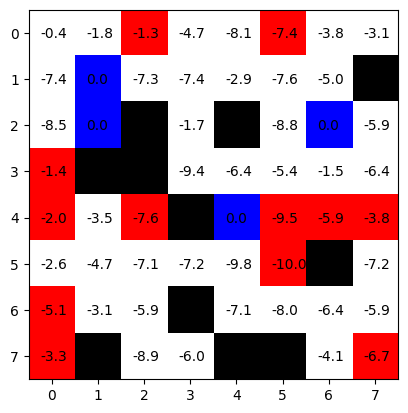

In [84]:
values = init_values(env)
draw_values(env, values)

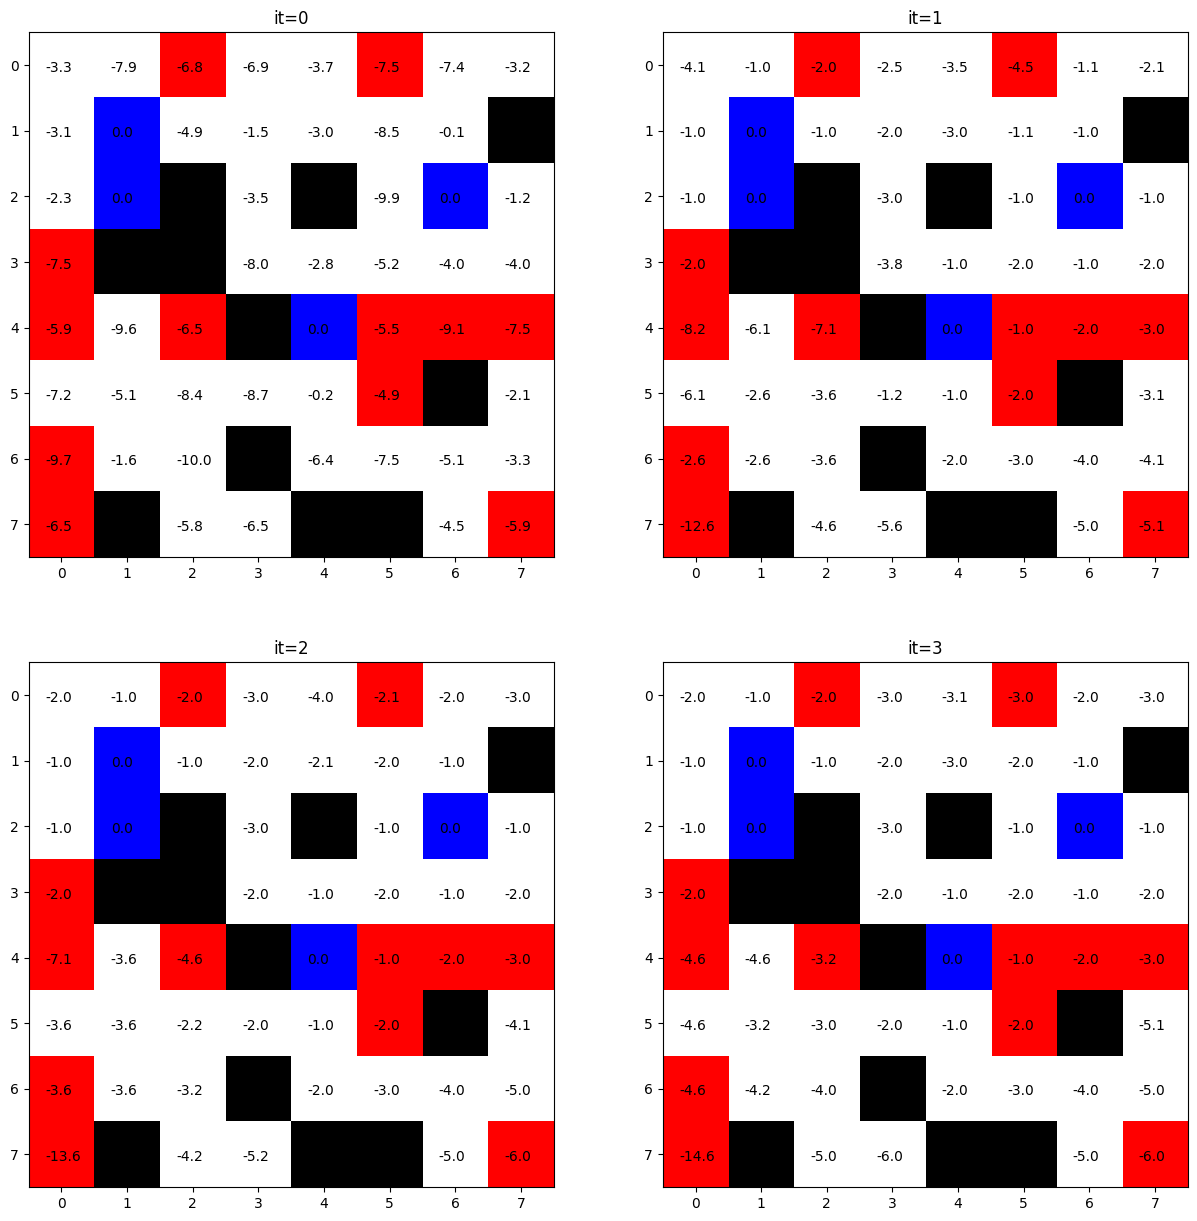

In [85]:
nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
axes = axes.flatten()
values = init_values(env)
for k in range(nrows*ncols):
    draw_values(env, values, ax)
    axes[k].set_title(f"it={k}")
    draw_values(env, values, ax=axes[k])
    values = async_update_all_values(env, values, 1.0)

We are finally ready to implement the value iteration algorithm.

In [86]:
def value_iteration(env, gamma, eps, v0=None, maxiter=100):
    v = v0 if v0 is not None else init_values(env)
    for k in range(maxiter):
        nv = async_update_all_values(env, values, gamma)
        err = max([abs(nv[s] - v[s]) for s in v])
        if err<eps:
            return nv, k
        v = nv
    return v, k

Let us test the algorithm by 

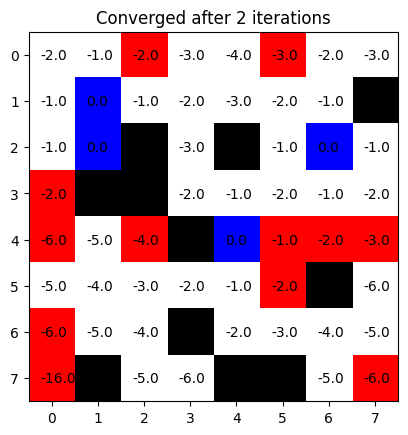

In [87]:
fin_v, k = value_iteration(env, 1.0, 0.01)
draw_values(env, fin_v)
plt.title(f"Converged after {k} iterations");

## Finding and Visualizing Optimal Decision Policy

Let us first define a function that computes a greedy action (with respect to the given state values) for a specific given state.

In [88]:
def greedy_action(env, s, v, gamma):
    vs = []
    for a in env.get_actions():
        s_next, r, _ = env(s, a)
        vs.append(r + gamma*v[s_next])
    return np.argmax(vs)

Let us test it to see if we are getting the expected result. Notice that our function will return just a single action, even if there are more than one possibility.

In [91]:
aopt = greedy_action(env, (5, 4), fin_v, 1.0)
ACTIONS[aopt]

'UP'

We can now compute the full optimal policy

In [92]:
def optimal_policy(env, v, gamma):
    return {s: greedy_action(env, s, v, gamma) for s in env.get_states() if not env.is_terminal(s)}

It is also helpfull to have a function for visualization of policies.

In [190]:
def action_symbol(a):
    if a == RIGHT:
        return "→"
    elif a==UP:
        return "↑"
    elif a==LEFT:
        return "←"
    elif a == DOWN:
        return "↓"
    else:
        raise Exception("Unknown action")

def draw_policy(env, policy, ax=None):
    ax = ax if ax is not None else plt
    draw_board(env.board, ax=ax)
    for s, a in policy.items():
        ax.text(s[1]-0.25, s[0]+0.1, action_symbol(a))

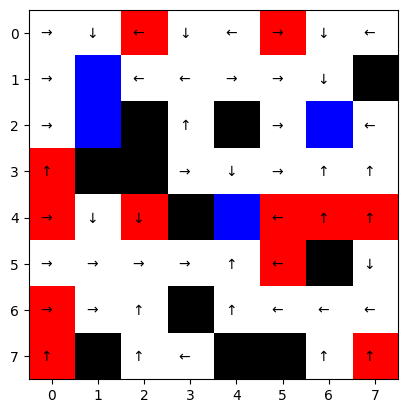

In [94]:
pi = optimal_policy(env, fin_v, 1.0)
draw_policy(env, pi)

## Assignments for Individual Work (Level 1)

1. Add TELEPORT CELLS and modify the code to accomodate this kind of cells also.
2. Implement value iteration algorithm using Q function instead of V function.
3. Implement policy iteration algorithm using both V and Q functions.

In all cases update, modify, and add visualization facilities to illustrate correctness of the implementation.

## Assignments for Individual Work (Level 2)

1. Modify the code assuming that the maze is stochastic (so that a given action in a given cell may result with different outcomes with different known probabilities)
2. Repeat Level 1 assignments for this kind of maze.

## Assignments for Individual Work (Level 3)

1. Repeat Level 1 assignments assuming that the Maze is graph-like and not grid-like, so that there are different possible actions to take from each cell.


# REŠENJE:

---
## Level 1
---
  ### 1.) Dodavanje TELEPORT ĆELIJA i modifikacija koda :

In [95]:
# 1. Korak: Potrebno je definisati klasu TeleportCell
class TeleportCell(Cell):
    def __init__(self, reward: float, destination: tuple[int, int]):
        self.reward = reward
        self.destination = destination # Koordinate destinacije nakon teleporta

    def get_reward(self) -> float:
        return self.reward

    def get_destination(self) -> tuple[int, int]:
        return self.destination

    def is_steppable(self) -> bool:
        return True

    def is_terminal(self) -> bool:
        return False

    def has_value(self) -> bool:
        return False

# 2. Korak: Potrebno je redefinisati funkciju za bojenje ćelija kako bi Teleport ćelije bile npr. zelene boje
def default_cell_color(cell: Cell) -> tuple[int, int, int]:
    if isinstance(cell, RegularCell):
        if cell.get_reward() == -1:
            return (255, 255, 255)          # Bela boja za Regularnu ćeliju
        else:
            return (255, 0, 0)              # Crvena boja za Kaznenu ćeliju
    elif isinstance(cell, WallCell):
        return (0, 0, 0)                    # Crna boja za ćeliju Zid
    elif isinstance(cell, TerminalCell):
        return (0, 0, 255)                  # Plava boja za Terminalnu ćeliju
    elif isinstance(cell, TeleportCell):
        return (0, 255, 0)                  # Zelena boja za Teleport ćeliju
    else:
        return (200, 200, 200)              # Siva boja za nepoznatu ćeliju, ukoliko postoji

def draw_board(board: MazeBoard, color = default_cell_color, pos: tuple[int, int] = None, ax=None):
    ax = ax if ax is not None else plt
    board_img = np.ones(shape=(board.rows_no, board.cols_no, 3), dtype=np.uint8)
    for i in range(board.rows_no):
        for j in range(board.cols_no):
            board_img[i, j, :] = color(board[i, j])
    if pos is not None:
        row, col = pos
        ax.text(col-0.1, row+0.1, "X", fontweight="bold")
    if ax is not None:
        ax.imshow(board_img)
    else:
        plt.imshow(board_img)

# 3. Korak : Potrebno je redefinisati MazeEnvironment kako bi podržao logiku teleportovanja
class MazeEnvironment:
    def __init__(self, board: MazeBoard):
        self.board = board

    def move_up_from(self, row: int, col: int) -> tuple[int, int]:
        if row != 0 and self.board[row-1, col].is_steppable():
            return (row-1, col)
        else:
            return (row, col)

    def move_down_from(self, row: int, col: int) -> tuple[int, int]:
        if row != self.board.rows_no - 1 and self.board[row+1, col].is_steppable():
            return (row+1, col)
        else:
            return (row, col)

    def move_left_from(self, row: int, col: int) -> tuple[int, int]:
        if col != 0 and self.board[row, col-1].is_steppable():
            return (row, col-1)
        else:
            return (row, col)

    def move_right_from(self, row: int, col: int) -> tuple[int, int]:
        if col != self.board.cols_no - 1 and self.board[row, col+1].is_steppable():
            return (row, col+1)
        else:
            return (row, col)

    def move_from(self, row: int, col: int, action: int) -> tuple[int, int]:
        if action == RIGHT:
            return self.move_right_from(row,col)
        elif action == UP:
            return self.move_up_from(row,col)
        elif action == LEFT:
            return self.move_left_from(row,col)
        elif action == DOWN:
            return self.move_down_from(row,col)
        else:
            raise Exception("Invalid action.")

    def __call__(self, state: tuple[int, int], action: int) -> tuple[tuple[int, int], float, bool]:
        row, col = state
        new_row, new_col = self.move_from(row, col, action)
        new_cell = self.board[new_row, new_col]
        if isinstance(new_cell, TeleportCell):                  # Provera da li je nova ćelija Teleport ćelija
            dest_row, dest_col = new_cell.get_destination()     # Dobijanje destinacije teleporta (ćelije na koju smo došli nakon teleporta)
            final_cell = self.board[dest_row, dest_col]         # Formiranje odredišne ćelije teleporta
            reward = final_cell.get_reward()                    # Dobijanje nagrade za prelazak na odredišnu destinaciju teleporta
            is_terminal = final_cell.is_terminal()              # Provera da li je destinacija terminalna ćelija
            return (dest_row, dest_col), reward, is_terminal    # Vraćamo koordinate te ćelije u kojoj se nalazimo, nagradu i status terminalnosti

        else:
            reward = new_cell.get_reward()                      # Ako ćelija nije Teleport ćelija, dobijamo nagradu standardno obračunavamo nagradu
            is_terminal = new_cell.is_terminal()                # Provera da li je ćelija terminalna
            return (new_row, new_col), reward, is_terminal      # Vraćamo koordinate te ćelije u kojoj se nalazimo, nagradu i status terminalnosti

    def get_states(self):
        states = []
        for r in range(self.board.rows_no):
            for c in range(self.board.cols_no):
                if self.board[r, c].is_steppable():
                    states.append((r, c))
        return states

    def is_terminal(self, s):
        return self.board[s[0], s[1]].is_terminal()

    def get_actions(self):
        return [RIGHT, UP, LEFT, DOWN]

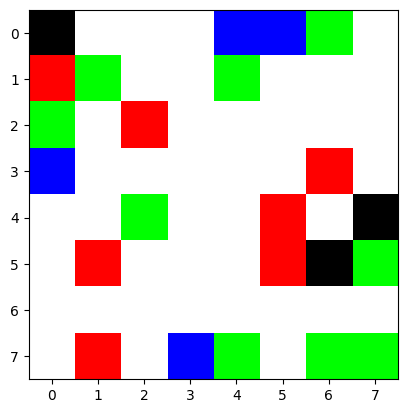

In [97]:
# Testiranje i vizualizacija

specs = [
    (10, lambda: RegularCell(-1)),
    (2, lambda: RegularCell(-10)),
    (2, lambda: WallCell()),
    (1, lambda: TerminalCell(-1)),
    (2, lambda: TeleportCell(0, destination=(0, 0)))
]

board_with_teleport = create_random_board(size=(8, 8), specs = specs)
draw_board(board_with_teleport)

**Komentar :** *`Teleport ćelije` se uspešno stvaraju i iscrtavaju na Board-u.*

In [98]:
cells_oneway_teleport = [
    [WallCell(),        WallCell(),                              WallCell(),        WallCell(),        WallCell(),                                WallCell()     ],
    [RegularCell(-10),  RegularCell(-10),                        RegularCell(-1),   TerminalCell(-1),  TerminalCell(-1),                          RegularCell(-1)],
    [RegularCell(-1),   TeleportCell(0, destination=(2, 4)),    RegularCell(-1),   RegularCell(-1),   TeleportCell(0, destination=(2,4)),       RegularCell(-1)],
    [TerminalCell(-1),  RegularCell(-1),                         RegularCell(-10),  RegularCell(-1),   WallCell(),                                RegularCell(-1)],
    [WallCell(),        WallCell(),                              WallCell(),        WallCell(),        WallCell(),                                WallCell()     ]
]

board_oneway_teleport = MazeBoard(cells_oneway_teleport)
env_oneway_teleport = MazeEnvironment(board_oneway_teleport)

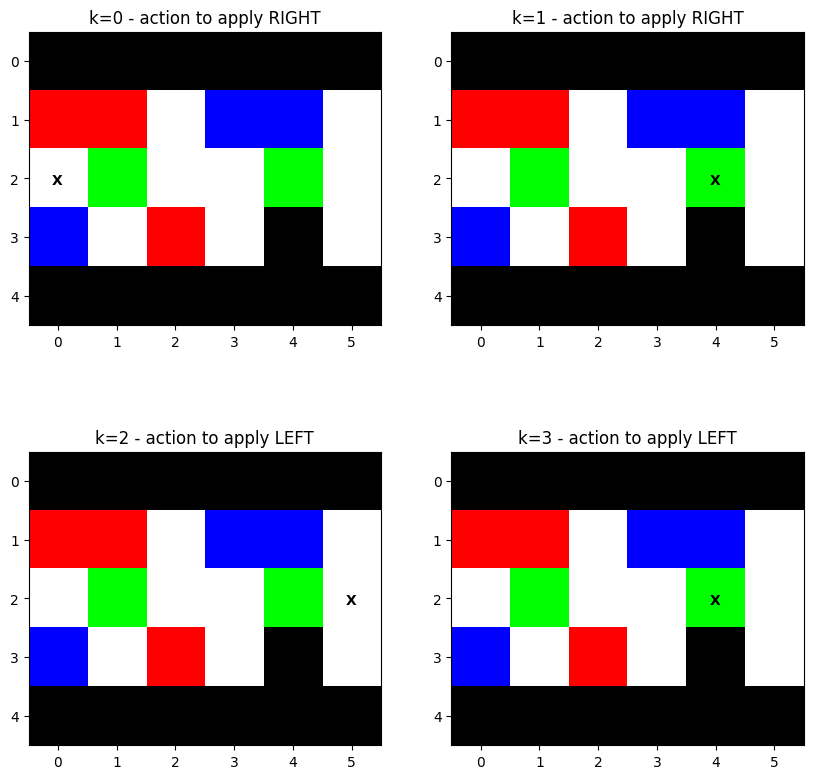

In [99]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axes = axes.flatten()
axes
state = (2, 0)
actions = [RIGHT, RIGHT, LEFT, LEFT]
for k, (a, ax) in enumerate(zip(actions, axes)):
    ax.set_title(f"k={k} - action to apply {ACTIONS[a]}")
    draw_board(board_oneway_teleport, pos=state, ax=ax)
    state, reward, terminal = env_oneway_teleport(state, a)

**Komentar:** *Kao što možemo da vidimo, `Teleport polje` **jednosmernog tipa** je uspešno kreirano i na odgovarajući način vrši svoju funkciju.*


In [100]:
cells_oneway_teleport = [
    [WallCell(),        WallCell(),                              WallCell(),        WallCell(),        WallCell(),                                WallCell()     ],
    [RegularCell(-10),  RegularCell(-10),                        RegularCell(-1),   TerminalCell(-1),  TerminalCell(-1),                          RegularCell(-1)],
    [RegularCell(-1),   TeleportCell(0, destination=(2, 4)),    RegularCell(-1),   RegularCell(-1),   TeleportCell(0, destination=(2,1)),       RegularCell(-1)],
    [TerminalCell(-1),  RegularCell(-1),                         RegularCell(-10),  RegularCell(-1),   WallCell(),                                RegularCell(-1)],
    [WallCell(),        WallCell(),                              WallCell(),        WallCell(),        WallCell(),                                WallCell()     ]
]

board_oneway_teleport = MazeBoard(cells_oneway_teleport)
env_oneway_teleport = MazeEnvironment(board_oneway_teleport)

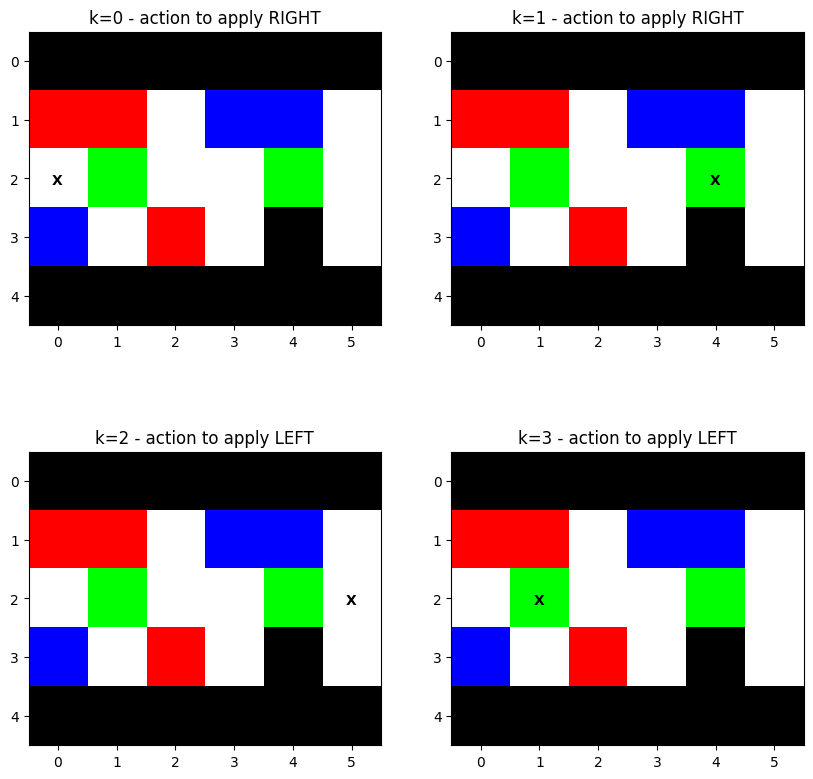

In [101]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axes = axes.flatten()
axes
state = (2, 0)
actions = [RIGHT, RIGHT, LEFT, LEFT]
for k, (a, ax) in enumerate(zip(actions, axes)):
    ax.set_title(f"k={k} - action to apply {ACTIONS[a]}")
    draw_board(board_oneway_teleport, pos=state, ax=ax)
    state, reward, terminal = env_oneway_teleport(state, a)

**Komentar:** *U ovom primeru možemo da vidimo da je `Teleport polje` **dvosmernog tipa** uspešno kreirano i da na odgovarajući način vrši svoju funkciju.*


**Napomena :** *Eksperimenti i rešenja koja slede će biti implementirana pomoću **jednosmernog** tipa `Teleport polja`.*

### Iteriranje po vrednostima oslanjajući se na V funkciju uzimajući u obzir egzistenciju Teleport polja na Board-u

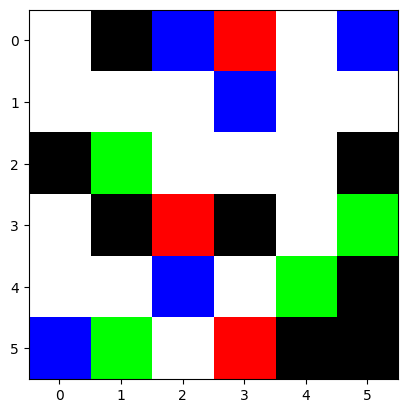

In [102]:
# 1. Korak: Kreiramo prilagođenu tablu 6x6 sa Teleport ćelijama

cells_with_teleport = [
    [RegularCell(-1),   WallCell(),                             TerminalCell(-1),   RegularCell(-10),  RegularCell(-1),                         TerminalCell(-1)],
    [RegularCell(-1),   RegularCell(-1),                        RegularCell(-1),    TerminalCell(-1),  RegularCell(-1),                         RegularCell(-1)],
    [WallCell(),        TeleportCell(0, destination=(4, 4)),    RegularCell(-1),    RegularCell(-1),   RegularCell(-1),                         WallCell()],
    [RegularCell(-1),   WallCell(),                             RegularCell(-10),   WallCell(),        RegularCell(-1),                         TeleportCell(0, destination=(5, 1))],
    [RegularCell(-1),   RegularCell(-1),                        TerminalCell(-1),   RegularCell(-1),   TeleportCell(0, destination=(4, 4)),     WallCell()],
    [TerminalCell(-1),  TeleportCell(0, destination=(5, 1)),    RegularCell(-1),    RegularCell(-10),  WallCell(),                              WallCell()]
]

board_teleport = MazeBoard(cells_with_teleport)
env_teleport = MazeEnvironment(board_teleport)

# Vizualizacija Board-a
draw_board(board_teleport)

**Napomena :** Maze je napravljen ručno radi lakše analize tačnosti i ispravnosti. Kao što je navedeno iznad, implementirana su `Teleport polja` **jednosmernog tipa** i to u parovima `(2,1)->(4,4)` i `(3,5)->(5,1).`

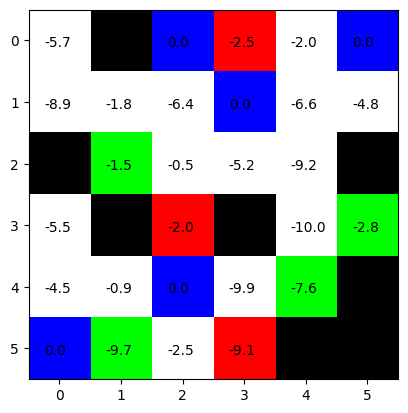

In [106]:
values = init_values(env_teleport)
draw_values(env_teleport, values)

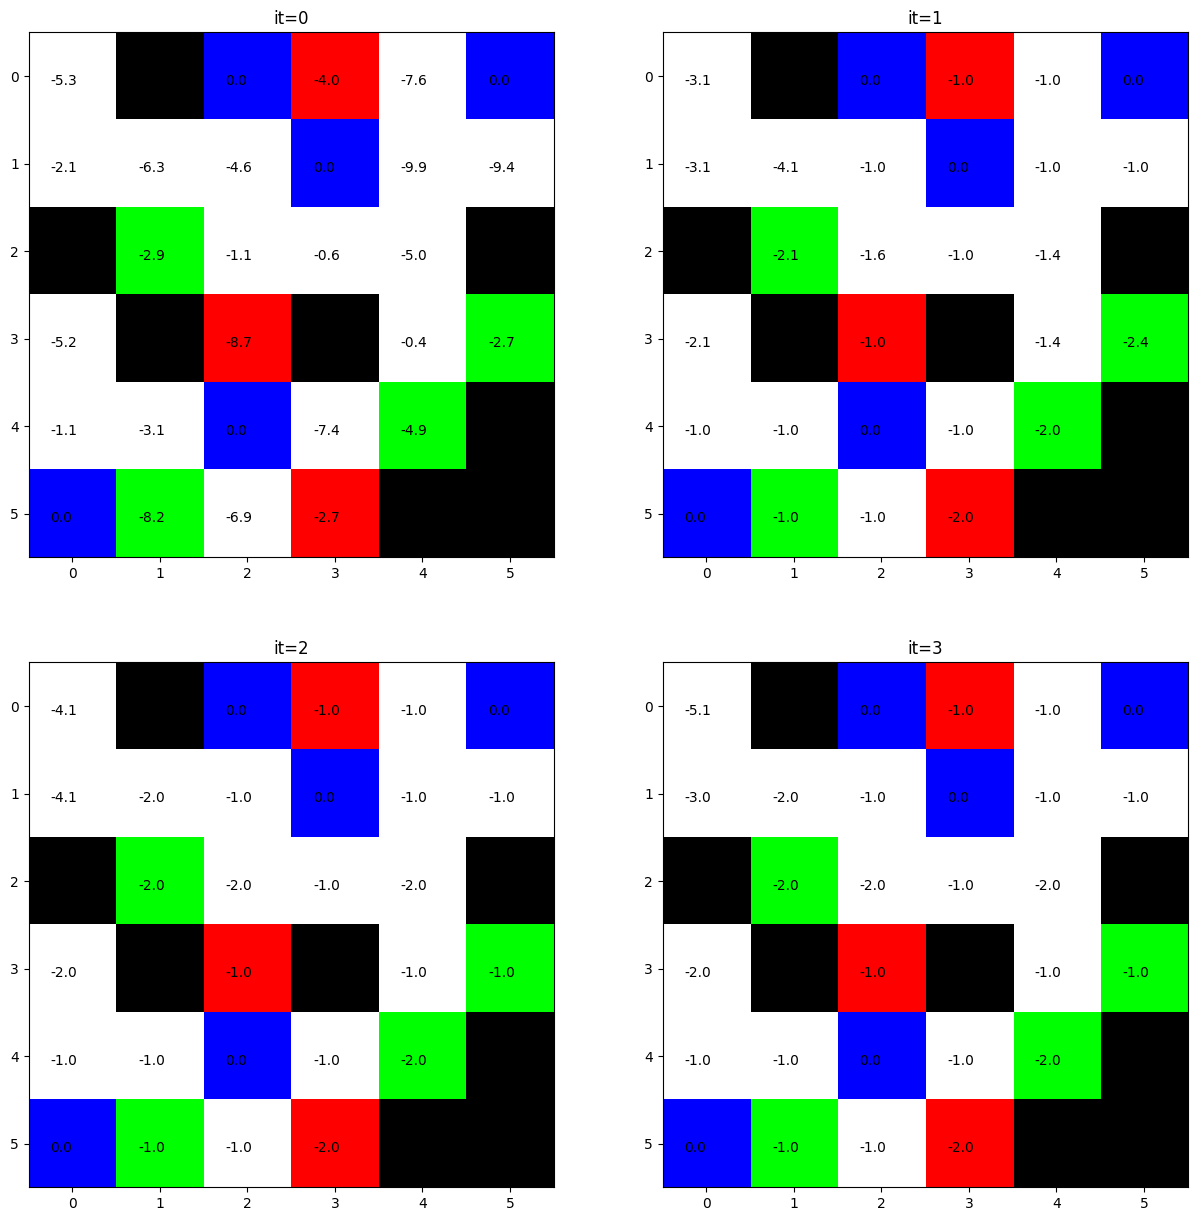

In [110]:
nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
axes = axes.flatten()
values = init_values(env_teleport)
for k in range(nrows*ncols):
    draw_values(env_teleport, values, ax)
    axes[k].set_title(f"it={k}")
    draw_values(env_teleport, values, ax=axes[k])
    values = async_update_all_values(env_teleport, values, 1.0)

**Komentar :** *Na osnovu prikazanih vrednosti stanja kroz iteracije lako dolazimo do zaključka baziranom na prve 3 iteracije, da je logika teleport polja ispravna i da algoritam funkcioniše kako treba.*

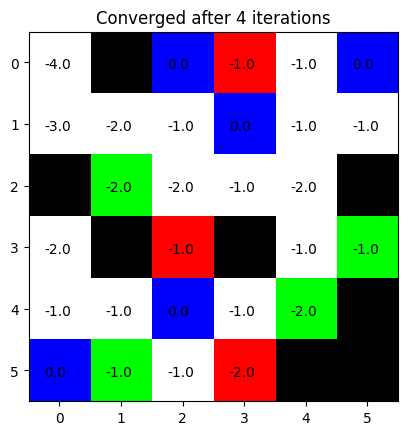

In [127]:
k = 0 # Resetovanje brojača iteracija
values = init_values(env_teleport)  # Resetovanje inicijalnih vrednosti
fin_v, k = value_iteration(env_teleport, 1.0, 0.01)
draw_values(env_teleport, fin_v)
plt.title(f"Converged after {k} iterations");

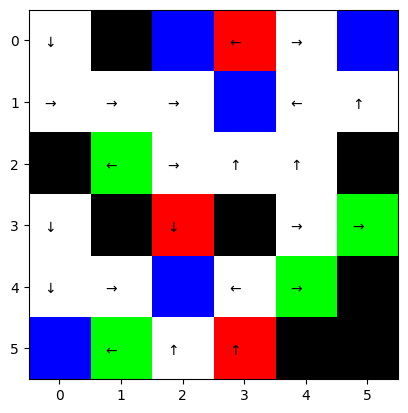

In [128]:
pi = optimal_policy(env_teleport, fin_v, 1.0)
draw_policy(env_teleport, pi)


In [130]:
r,l,u,d = 0,0,0,0
for s in env_teleport.get_states():
    if (greedy_action(env_teleport, s, fin_v, 1.0)) is RIGHT:
        r+=1
    elif (greedy_action(env_teleport, s, fin_v, 1.0)) is LEFT:
        l+=1
    elif (greedy_action(env_teleport, s, fin_v, 1.0)) is UP:
        u+=1
    elif (greedy_action(env_teleport, s, fin_v, 1.0)) is DOWN:
        d+=1
    
ACTIONS[max(r,l,u,d)]

'RIGHT'

**Komentar :** *Sa slike možemo zaključiti da je algoritam uspešno sproveden i da je generalno gledano polazeći iz bilo kog stanja i koristeći greedy action, optimalna akcija tj. akcija koju je statistički najbojle igrati u trenutnom stanju posmatrano na nivou Board-a `RIGHT`.*

---

### 2.) Implementacija iteriranja po Q vrednostima :

In [131]:
# 1. Korak: Potrebno je redefinisati funkcije za iteraciju po vrednostima
def init_q_values(env):
    """Inicijalizacija Q-vrednosti za sve parove (stanje, akcija)"""
    q = {}
    for s in env.get_states():
        for a in env.get_actions():
            if env.is_terminal(s):
                q[(s, a)] = 0
            else:
                q[(s, a)] = -10 * random()
    return q

def update_q_value(env, s, a, q, gamma):
    """Ažuriranje Q-vrednosti za dati par (stanje, akcija)"""
    s_next, r, _ = env(s, a)

    if env.is_terminal(s_next):
        return r
    
    max_q_next = max([q[(s_next, a_next)] for a_next in env.get_actions()])
    
    # Q(s,a) = R(s,a) + gamma * max_a' Q(s', a')
    return r + gamma * max_q_next

def async_update_all_q_values(env, q, gamma):
    """Ažuriranje Q-vrednosti za sve parove (stanje, akcija)"""
    for s in env.get_states():
        for a in env.get_actions():
            if not env.is_terminal(s):
                q[(s, a)] = update_q_value(env, s, a, q, gamma)
    return copy(q)

def q_value_iteration(env, gamma, eps, q0=None, maxiter=100):
    q = q0 if q0 is not None else init_q_values(env)

    for k in range(maxiter):
        nq = async_update_all_q_values(env, q, gamma)
        err = max([abs(nq[(s, a)] - q[(s, a)]) for s in env.get_states() for a in env.get_actions()])

        if err < eps:
            return nq, k
        q = nq
        
    return q, k

In [132]:
fin_q, k = q_value_iteration(env_teleport, 0.95, 0.001)

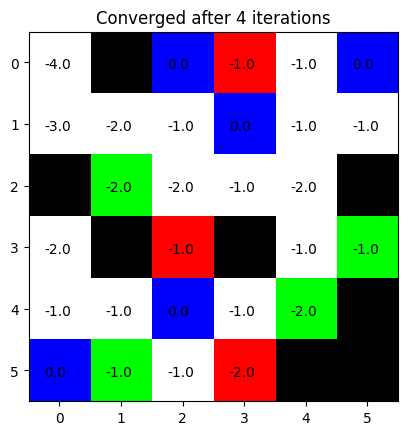

In [133]:
values = init_values(env_teleport)  # Resetovanje inicijalnih vrednosti
fin_q, k = value_iteration(env_teleport, 1.0, 0.01)
draw_values(env_teleport, fin_q)
plt.title(f"Converged after {k} iterations");

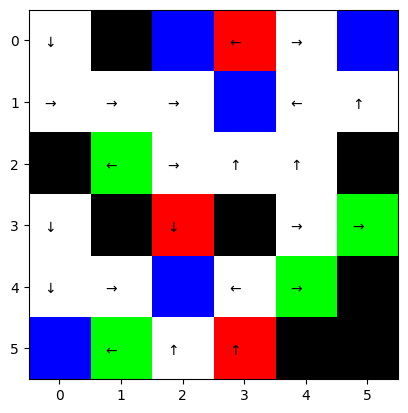

In [134]:
pi = optimal_policy(env_teleport, fin_v, 1.0)
draw_policy(env_teleport, pi)

### 3.) Implementacija iteriranja po politikama koristeći Q i V funkcije :

In [138]:
# Iteriranje po politikama oslanjajući se na V-funkciju

def policy_eval_v(env, policy, v, gamma, eps, maxiter=100):
    """Evaluiranje date politike: izračunavanje V(s) za datu politiku."""
    for iteration in range(maxiter):
        v_old = copy(v)
        for s in env.get_states():
            if not env.is_terminal(s):
                a = policy[s]
                s_next, r, _ = env(s, a)
                v[s] = r + gamma * v[s_next]
        error = max([abs(v[s] - v_old[s]) for s in env.get_states()])
        if error < eps:
            break
    return v

def policy_improvement_v(env, policy, v, gamma):
    """Poboljšanje politike koristeći trenutne procene vrednosti stanja."""
    for s in env.get_states():
        if not env.is_terminal(s):
            policy[s] = greedy_action(env, s, v, gamma)
    return policy

def policy_iteration_v(env, gamma, eps, maxiter=100):
    """Iteriranje po politikama oslanjajući se na V-funkciju."""
    policy = {s: 0 for s in env.get_states() if not env.is_terminal(s)}  # Inicijalizacija politike
    v = init_values(env)
    iteration_history = []
    for iteration in range(maxiter):
        v = policy_eval_v(env, policy, v, gamma, eps)
        policy_old = copy(policy)
        policy = policy_improvement_v(env, policy, v, gamma)
        # Provera da li se politika konvergirala
        if all(policy[s] == policy_old[s] for s in policy):
            iteration_history.append(iteration + 1)
            return policy, v, iteration + 1, iteration_history
        iteration_history.append(iteration + 1)
    
    return policy, v, maxiter, iteration_history

#-------------------------------------------------------------------------------------

# Iteriranje po politikama oslanjajući se na Q-funkciju

def policy_eval_q(env, policy, q, gamma, eps, maxiter=100):
    """Evaluiranje date politike: izračunavanje Q(s,a) za datu politiku."""
    for iteration in range(maxiter):
        q_old = copy(q)
        for s in env.get_states():
            if not env.is_terminal(s):
                # Ažuriranje Q vrednosti za svaku akciju u trenutnom stanju
                for a in env.get_actions():
                    s_next, r, _ = env(s, a)
                    if env.is_terminal(s_next):
                        q[(s, a)] = r
                    else:
                        # Uzimamo akciju koju nalaže politika za sledeće stanje
                        a_next = policy[s_next]
                        q[(s, a)] = r + gamma * q[(s_next, a_next)]
        error = abs(q[(s, a)] - q_old[(s, a)])
        if error < eps:
            break
    return q

def policy_improvement_q(env, policy, q):
    """Poboljšanje politike koristeći trenutne procene Q-vrednosti."""
    for s in env.get_states():
        if not env.is_terminal(s):
            policy[s] = max(range(len(env.get_actions())), key=lambda a: q[(s, a)])
    return policy

def policy_iteration_q(env, gamma, eps, maxiter=100):
    """Iteriranje po politikama oslanjajući se na Q-funkciju."""
    policy = {s: 0 for s in env.get_states() if not env.is_terminal(s)}
    q = init_q_values(env)
    iteration_history = []
    
    for iteration in range(maxiter):
        q = policy_eval_q(env, policy, q, gamma, eps)
        policy_old = copy(policy)
        policy = policy_improvement_q(env, policy, q)
        
        if all(policy[s] == policy_old[s] for s in policy):
            iteration_history.append(iteration + 1)
            return policy, q, iteration + 1, iteration_history
        iteration_history.append(iteration + 1)
    
    return policy, q, maxiter, iteration_history

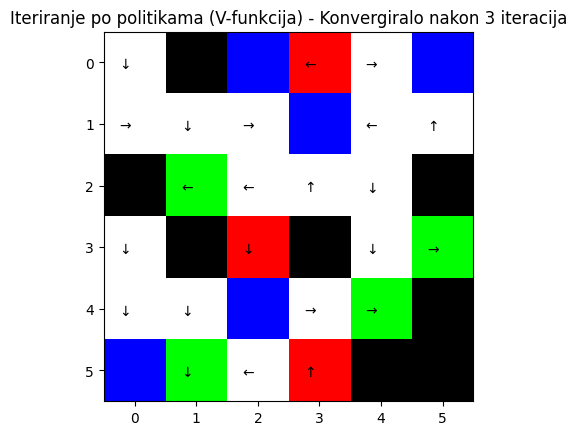

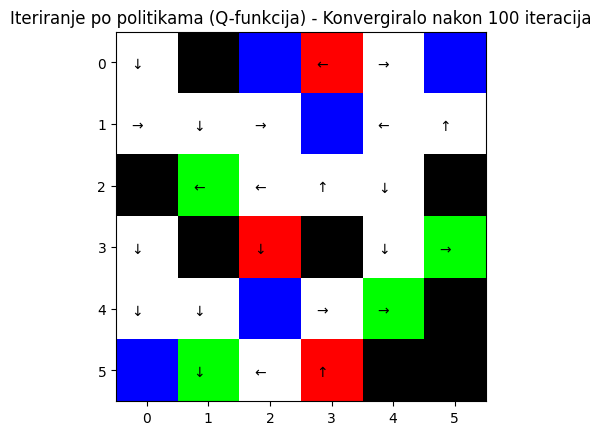

In [139]:
# Testiranje iteracije po politikama sa V-funkcijom
pi_v, v_pi, k_v, hist_v = policy_iteration_v(env_teleport, 0.95, 0.001)
draw_policy(env_teleport, pi_v)
plt.title(f"Iteriranje po politikama (V-funkcija) - Konvergiralo nakon {k_v} iteracija")
plt.show()

# Testiranje iteracije po politikama sa Q-funkcijom
pi_q, q_pi, k_q, hist_q = policy_iteration_q(env_teleport, 0.95, 0.001)
draw_policy(env_teleport, pi_q)
plt.title(f"Iteriranje po politikama (Q-funkcija) - Konvergiralo nakon {k_q} iteracija")
plt.show()

---
## Level 2
---
   ### 1.) Modifikacija koda tako da je MAZE stohastički (svaka akcija ćelije tj. stanje u kom se trenutno nalazimo se dešava sa određenom verovatnoćom odnosno u svaku ćeliju dospevamo/ne dospevamo sa određenom verovatnoćom) :

In [140]:
# LEVEL 2: STOCHASTIC MAZE

#1. Korak: Kreiranje stohastičkog okruženja

class StochasticMazeEnvironment:
    """
    MPO okruženje sa stohastičkim (verovatnosnim) tranzicijama.
    
    Kada agent preduzme akciju, postoji verovatnoća p_success da akcija uspe,
    u suprotnom agent "klizne" u nasumičnom susednom pravcu.
    """
    
    def __init__(self, board: MazeBoard, p_success: float = 0.8):
        """
        Args:
            board: Maze board
            p_success: Verovatnoća uspešne tranzicije (0 < p_success < 1)
            p_slip: Verovatnoća "klizanja" u neki od ostalih pravaca
        """
        
        self.board = board
        self.p_success = p_success
        self.p_slip = (1 - p_success) / 3  # Distribuirano ravnomerno u odnosu na ostale akcije
    
    def move_up_from(self, row: int, col: int) -> tuple[int, int]:
        if row != 0 and self.board[row-1, col].is_steppable():
            return (row-1, col)
        else:
            return (row, col)
    
    def move_down_from(self, row: int, col: int) -> tuple[int, int]:
        if row != self.board.rows_no - 1 and self.board[row+1, col].is_steppable():
            return (row+1, col)
        else:
            return (row, col)
    
    def move_left_from(self, row: int, col: int) -> tuple[int, int]:
        if col != 0 and self.board[row, col-1].is_steppable():
            return (row, col-1)
        else:
            return (row, col)
    
    def move_right_from(self, row: int, col: int) -> tuple[int, int]:
        if col != self.board.cols_no - 1 and self.board[row, col+1].is_steppable():
            return (row, col+1)
        else:
            return (row, col)
    
    def move_from(self, row: int, col: int, action: int) -> tuple[int, int]:
        if action == RIGHT:
            return self.move_right_from(row, col)
        elif action == UP:
            return self.move_up_from(row, col)
        elif action == LEFT:
            return self.move_left_from(row, col)
        elif action == DOWN:
            return self.move_down_from(row, col)
        else:
            raise Exception("Invalid action.")
    
    def get_transition_distribution(self, state: tuple[int, int], action: int) -> dict:
        """
        Vraća distribuciju tranzicija za dati par (stanje, akcija).
        
        Vraća rečnik gde su ključevi (next_state, reward, is_terminal)
        a vrednosti su verovatnoće tih tranzicija.
        """
        row, col = state
        
        # Uspešna tranzicija
        next_row, next_col = self.move_from(row, col, action)
        next_cell = self.board[next_row, next_col]
        
        if isinstance(next_cell, TeleportCell):
            dest_row, dest_col = next_cell.get_destination()
            final_cell = self.board[dest_row, dest_col]
            reward = final_cell.get_reward()
            is_terminal = final_cell.is_terminal()
            next_state = (dest_row, dest_col)
        else:
            reward = next_cell.get_reward()
            is_terminal = next_cell.is_terminal()
            next_state = (next_row, next_col)
        
        distribution = {(next_state, reward, is_terminal): self.p_success}
        
        # "Klizne" tranzicije
        other_actions = [a for a in self.get_actions() if a != action]
        for slip_action in other_actions:
            slip_row, slip_col = self.move_from(row, col, slip_action)
            slip_cell = self.board[slip_row, slip_col]
            
            if isinstance(slip_cell, TeleportCell):
                slip_dest_row, slip_dest_col = slip_cell.get_destination()
                slip_final_cell = self.board[slip_dest_row, slip_dest_col]
                slip_reward = slip_final_cell.get_reward()
                slip_is_terminal = slip_final_cell.is_terminal()
                slip_state = (slip_dest_row, slip_dest_col)
            else:
                slip_reward = slip_cell.get_reward()
                slip_is_terminal = slip_cell.is_terminal()
                slip_state = (slip_row, slip_col)
            
            key = (slip_state, slip_reward, slip_is_terminal)
            distribution[key] = distribution.get(key, 0) + self.p_slip
        
        return distribution
    
    def get_states(self):
        states = []
        for r in range(self.board.rows_no):
            for c in range(self.board.cols_no):
                if self.board[r, c].is_steppable():
                    states.append((r, c))
        return states
    
    def is_terminal(self, s):
        return self.board[s[0], s[1]].is_terminal()
    
    def get_actions(self):
        return [RIGHT, UP, LEFT, DOWN]

In [141]:
# Iteriranje po vrednostima u stohastičkom okruženju

def update_state_value_stochastic(env: StochasticMazeEnvironment, s, v, gamma):
    """Ažuriranje vrednosti stanja u stohastičkom okruženju."""
    rhs = []
    for a in env.get_actions():
        distribution = env.get_transition_distribution(s, a)
        action_value = 0
        for (s_next, r, is_terminal), prob in distribution.items():
            if is_terminal:
                action_value += prob * r
            else:
                action_value += prob * (r + gamma * v[s_next])
        rhs.append(action_value)
    return max(rhs)

def async_update_all_values_stochastic(env: StochasticMazeEnvironment, v, gamma):
    """Ažuriranje vrednosti svih stanja u stohastičkom okruženju."""
    for s in env.get_states():
        if not env.is_terminal(s):
            v[s] = update_state_value_stochastic(env, s, v, gamma)
    return copy(v)

def value_iteration_stochastic(env: StochasticMazeEnvironment, gamma, eps, maxiter=200):
    """Iteriranje po vrednostima za stohastičko okruženje."""
    v = init_values(env)
    
    for k in range(maxiter):
        v_old = copy(v)
        v = async_update_all_values_stochastic(env, v, gamma)
        error = max([abs(v[s] - v_old[s]) for s in v])
        
        if error < eps:
            return v, k + 1
    return v, maxiter

In [150]:
# Kreiranje stohastičkog okruženja sa teleportacijom koristeći prethodno definisanu tablu
env_stochastic = StochasticMazeEnvironment(board_teleport, p_success=0.8)

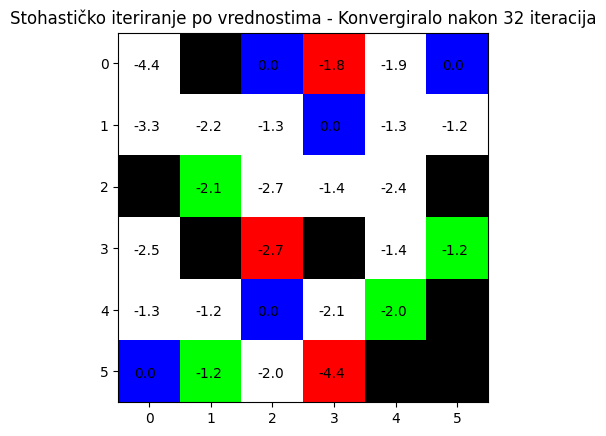

In [159]:
# Testiranje iteracije po vrednostima u stohastičkom okruženju
v_stoch, k_stoch = value_iteration_stochastic(env_stochastic, 0.95, 0.001)
draw_values(env_stochastic, v_stoch)
plt.title(f"Stohastičko iteriranje po vrednostima - Konvergiralo nakon {k_stoch} iteracija")
plt.show()

**Komentar :** *Na osnovu prikazanih iteracija možemo zaključiti da je logika stohastičkog Maze-a ispravna i da algoritam funkcioniše kako treba. Primetimo da difuzija vrednosti predstavlja ključnu razliku u odnosu na determinističko rešenje.
Dok su u determinističkom lavirintu vrednosti stanja bile "oštro" definisane rastojanjem do cilja, ovde vidimo "zamućene" vrednosti. Visoke vrednosti oko cilja se brže smanjuju kako se udaljavamo, a negativne vrednosti kaznenih polja "zrače" na susedna polja. To je zato što čak i u bezbednom polju pored zida ili kazne, agent ima 20% šanse da sklizne u opasno područje.*

In [160]:
# Poređenje determinističke i stohastičke iteracije po vrednostima
print(f"Deterministička iteracija po vrednostima konvergirala u {k} iteracija")
print(f"Stohastička iteracija po vrednostima konvergirala u {k_stoch} iteracija")

Deterministička iteracija po vrednostima konvergirala u 4 iteracija
Stohastička iteracija po vrednostima konvergirala u 32 iteracija


**Komentar :** *U determinističkom okruženju, informacija o nagradi se prostire veoma precizno i brzo kroz mrežu stanja. U stohastičkom okruženju, propagacija nagrade liči na "difuziju" ili širenje toplote. Zbog verovatnosnog šuma, potrebno je više prolaza (iteracija) da bi se fluktuacije usrednjile i da bi se vrednosti stabilizovale (konvergirale) na svojim pravim očekivanim vrednostima.*

### 2.) Rešavanje zadataka sa Level 1 za novu (stohastičku) strukturu MAZE-a :

In [161]:
# Iterriranje po Q-vrednostima u stohastičkom okruženju

def init_q_values_stochastic(env: StochasticMazeEnvironment):
    """Inicijalizacija Q-vrednosti u stohastičkom okruženju."""
    q = {}
    for s in env.get_states():
        for a in env.get_actions():
            if env.is_terminal(s):
                q[(s, a)] = 0
            else:
                q[(s, a)] = -10 * random()
    return q

def update_q_value_stochastic(env: StochasticMazeEnvironment, s, a, q, gamma):
    """Ažuriranje Q-vrednosti u stohastičkom okruženju."""
    distribution = env.get_transition_distribution(s, a)
    q_value = 0
    for (s_next, r, is_terminal), prob in distribution.items():
        if is_terminal:
            q_value += prob * r
        else:
            max_q_next = max([q[(s_next, a_next)] for a_next in env.get_actions()])
            q_value += prob * (r + gamma * max_q_next)
    return q_value

def async_update_all_q_values_stochastic(env: StochasticMazeEnvironment, q, gamma):
    """Ažuriranje svih Q-vrednosti u stohastičkom okruženju."""
    for s in env.get_states():
        for a in env.get_actions():
            if not env.is_terminal(s):
                q[(s, a)] = update_q_value_stochastic(env, s, a, q, gamma)
    return copy(q)

def q_value_iteration_stochastic(env: StochasticMazeEnvironment, gamma, eps, maxiter=200):
    """Iteriranje po Q-vrednostima u stohastičkom lavirintu."""
    q = init_q_values_stochastic(env)
    
    for k in range(maxiter):
        q_old = copy(q)
        q = async_update_all_q_values_stochastic(env, q, gamma)
        error = max([abs(q[(s, a)] - q_old[(s, a)]) for s in env.get_states() for a in env.get_actions()])
        
        if error < eps:
            return q, k + 1
    return q, maxiter

In [165]:
# Testiranje iteracije po Q-vrednostima u stohastičkom okruženju
q_stoch_final, k_stoch_q = q_value_iteration_stochastic(env_stochastic, 0.95, 0.001)

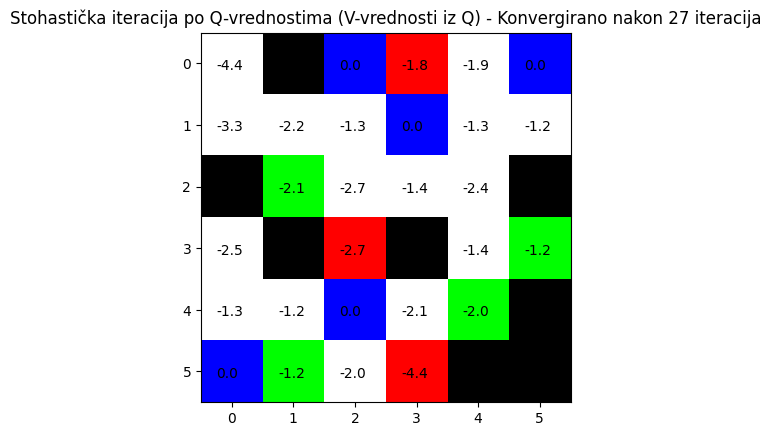

In [166]:
# Pretvaranje Q-vrednosti u V-vrednosti za vizualizaciju
v_from_q_stoch = {s: max([q_stoch_final[(s, a)] for a in env_stochastic.get_actions()]) for s in env_stochastic.get_states()}
draw_values(env_stochastic, v_from_q_stoch)
plt.title(f"Stohastička iteracija po Q-vrednostima (V-vrednosti iz Q) - Konvergirano nakon {k_stoch_q} iteracija")
plt.show()

In [164]:
# Izračunavanje optimalne politike u stohastičkom okruženju
def greedy_action_stochastic(env: StochasticMazeEnvironment, s, v, gamma):
    """Izračunaj pohlepnu akciju u stohastičkom okruženju."""
    best_action = 0
    best_value = float('-inf')
    for a in env.get_actions():
        distribution = env.get_transition_distribution(s, a)
        action_value = 0
        for (s_next, r, is_terminal), prob in distribution.items():
            if is_terminal:
                action_value += prob * r
            else:
                action_value += prob * (r + gamma * v[s_next])
        if action_value > best_value:
            best_value = action_value
            best_action = a
    return best_action

def optimal_policy_stochastic(env: StochasticMazeEnvironment, v, gamma):
    """Izračunaj optimalnu politiku u stohastičkom okruženju."""
    return {s: greedy_action_stochastic(env, s, v, gamma) for s in env.get_states() if not env.is_terminal(s)}

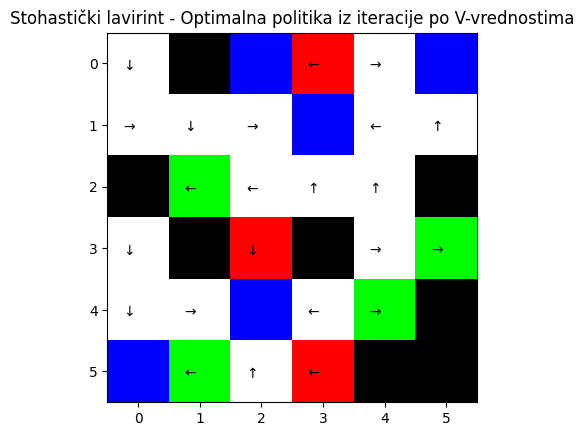

In [167]:
pi_stoch_v = optimal_policy_stochastic(env_stochastic, v_stoch, 0.95)
draw_policy(env_stochastic, pi_stoch_v)
plt.title("Stohastički lavirint - Optimalna politika iz iteracije po V-vrednostima")
plt.show()

**Komentar:** *Ako pažljivo pogledamo politiku (strelice) pored opasnih polja (kazne ili zidovi), videćemo da agent ponekad ne bira najkraći put. Na primer, umesto da ide direktno pored zida ka cilju, može se desiti da ode sredinom hodnika.
Ovo je direktna posledica stohastičnosti (p=0.8). Agent "žrtvuje" par koraka više da bi smanjio verovatnoću da slučajno sklizne u polje sa velikom negativnom nagradom.*

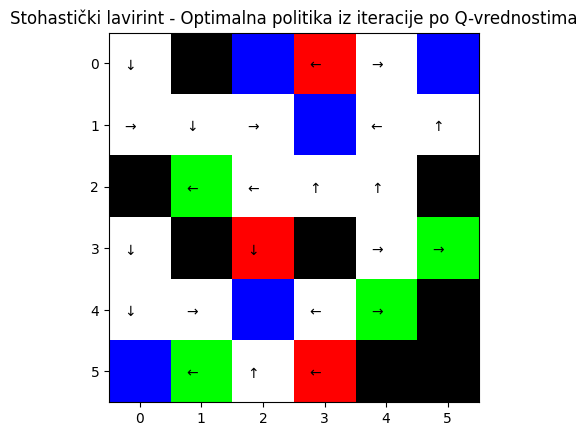

In [173]:
# Izvlačenje politike iz Q-vrednosti
def optimal_policy_from_q_stochastic(env: StochasticMazeEnvironment, q):
    """Izvlačenje optimalne politike iz Q-vrednosti."""
    policy = {}
    for s in env.get_states():
        if not env.is_terminal(s):
            policy[s] = max(range(len(env.get_actions())), key=lambda a: q[(s, a)])
    return policy

pi_stoch_q = optimal_policy_from_q_stochastic(env_stochastic, q_stoch_final)
draw_policy(env_stochastic, pi_stoch_q)
plt.title("Stohastički lavirint - Optimalna politika iz iteracije po Q-vrednostima")
plt.show()

In [170]:
# Iteracija po politikama u stohastičkom okruženju


# Iteracija po politikama koristeći V-funkciju

def policy_eval_v_stochastic(env: StochasticMazeEnvironment, policy, v, gamma, eps, maxiter=100):
    """
    Evaluacija politike koristeći V-funkciju u stohastičkom okruženju.
    
    Iterativno izračunava funkciju vrednosti V(s) za datu politiku.
    V^π(s) = E[R(s,a) + γ * V^π(s') | s, a=π(s)]
    
    Args:
        env: StochasticMazeEnvironment
        policy: Dict mapping states to actions
        v: Current value function (state -> value)
        gamma: Discount factor
        eps: Convergence threshold
        maxiter: Maximum iterations
    
    Returns:
        Updated value function v
    """
    for iteration in range(maxiter):
        v_old = copy(v)
        
        for s in env.get_states():
            if not env.is_terminal(s):
                a = policy[s]  # Uzeta akcija iz politike
                
                # Izračunavanje očekivane vrednosti: E[R + γ*V(s')]
                distribution = env.get_transition_distribution(s, a)
                v_new = 0
                for (s_next, r, is_terminal), prob in distribution.items():
                    if is_terminal:
                        v_new += prob * r
                    else:
                        v_new += prob * (r + gamma * v[s_next])
                
                v[s] = v_new
        
        # Provera konvergencije
        error = max([abs(v[s] - v_old[s]) for s in env.get_states()])
        if error < eps:
            return v
    
    return v


def policy_improvement_v_stochastic(env: StochasticMazeEnvironment, policy, v, gamma):
    """
    Unapređenje politike koristeći V-funkciju u stohastičkom okruženju.
    
    Izbor akcije koja maksimizuje očekivanu vrednost:
    π'(s) = argmax_a E[R(s,a) + γ * V(s') | s, a]
    
    Args:
        env: StochasticMazeEnvironment
        policy: Current policy (state -> action)
        v: Value function (state -> value)
        gamma: Discount factor
    
    Returns:
        Improved policy
    """
    for s in env.get_states():
        if not env.is_terminal(s):
            best_action = 0
            best_value = float('-inf')
            
            # Evaluacija svake moguće akcije
            for a in env.get_actions():
                distribution = env.get_transition_distribution(s, a)
                action_value = 0
                for (s_next, r, is_terminal), prob in distribution.items():
                    if is_terminal:
                        action_value += prob * r
                    else:
                        action_value += prob * (r + gamma * v[s_next])
                
                if action_value > best_value:
                    best_value = action_value
                    best_action = a
            
            policy[s] = best_action
    
    return policy


def policy_iteration_v_stochastic(env: StochasticMazeEnvironment, gamma, eps, maxiter=100):
    """
    Iteracija po politikama koristeći V-funkciju za stohastički lavirint.
    
    Naizmenično se izvode:
    1. Evaluacija politike: Izračunavanje V(s) za trenutnu politiku
    2. Unapređenje politike: Ažuriranje politike na greedy politiku u odnosu na V(s)
    
    Args:
        env: StochasticMazeEnvironment
        gamma: Discount factor
        eps: Convergence threshold
        maxiter: Maximum iterations
    
    Returns:
        policy: Optimal policy (state -> action)
        v: Value function (state -> value)
        iterations: Number of iterations to convergence
    """
    # Inicijalizacija politike nasumično i vrednosti na nulu
    policy = {s: 0 for s in env.get_states() if not env.is_terminal(s)}
    v = init_values(env)
    
    for iteration in range(maxiter):
        # Korak 1: Evaluacija politike
        v = policy_eval_v_stochastic(env, policy, v, gamma, eps)
        
        # Korak 2: Unapređenje politike
        policy_old = copy(policy)
        policy = policy_improvement_v_stochastic(env, policy, v, gamma)
        
        # Provera da li je politika konvergirala
        if all(policy[s] == policy_old[s] for s in policy):
            return policy, v, iteration + 1
    
    return policy, v, maxiter

In [171]:

# Iteracija po politikama koristeći Q-funkciju
def policy_eval_q_stochastic(env: StochasticMazeEnvironment, policy, q, gamma, eps, maxiter=100):
    """
    Evaluacija politike koristeći Q-funkciju u stohastičkom okruženju.
    
    Iterativno izračunava funkciju vrednosti Q(s,a) za datu politiku.
    Q^π(s,a) = E[R(s,a) + γ * Q^π(s', a') | s, a, a'=π(s')]
    
    Argumenti:
        env: StochasticMazeEnvironment
        policy: Rečnik koji mapira stanja na akcije
        q: Trenutne Q-vrednosti (stanje, akcija) -> q_vrednost
        gamma: Faktor diskontovanja
        eps: Prag konvergencije
        maxiter: Maksimalan broj iteracija
    
    Povratne vrednosti:
        Ažurirane Q-vrednosti
    """
    for iteration in range(maxiter):
        q_old = copy(q)
        
        for s in env.get_states():
            if not env.is_terminal(s):
                a = policy[s]  # Akcija određena politikom
                
                # Izračunavanje očekivane Q-vrednosti: E[R + γ*Q(s', π(s'))]
                distribution = env.get_transition_distribution(s, a)
                q_new = 0
                for (s_next, r, is_terminal), prob in distribution.items():
                    if is_terminal:
                        q_new += prob * r
                    else:
                        # Koristi akciju politike u sledećem stanju
                        a_next = policy[s_next]
                        q_new += prob * (r + gamma * q[(s_next, a_next)])
                
                q[(s, a)] = q_new
        
        # Provera konvergencije
        error = max([abs(q[(s, a)] - q_old[(s, a)]) 
                    for s in env.get_states() 
                    for a in env.get_actions()])
        if error < eps:
            return q
    
    return q


def policy_improvement_q_stochastic(env: StochasticMazeEnvironment, policy, q):
    """
    Unapređenje politike koristeći Q-funkciju u stohastičkom okruženju.
    
    Izbor akcije koja maksimizuje Q-vrednost:
    π'(s) = argmax_a Q(s,a)
    
    Argumenti
        env: StochasticMazeEnvironment
        policy: Trenutna politika (stanje -> akcija)
        q: Q-vrednosti (stanje, akcija) -> q_vrednost
    
    Povratne vrednosti:
        Unapređena politika
    """
    for s in env.get_states():
        if not env.is_terminal(s):
            best_action = 0
            best_q_value = float('-inf')
            
            for a in env.get_actions():
                if q[(s, a)] > best_q_value:
                    best_q_value = q[(s, a)]
                    best_action = a
            
            policy[s] = best_action
    
    return policy


def policy_iteration_q_stochastic(env: StochasticMazeEnvironment, gamma, eps, maxiter=100):
    """
    Iteracija po politikama koristeći Q-funkciju za stohastički lavirint.
    
    Naizmenično se izvode:
    1. Evaluacija politike: Izračunavanje Q(s,a) za trenutnu politiku
    2. Unapređenje politike: Ažuriranje politike na greedy politiku u odnosu na Q(s,a)
    
    Args:
        env: StochasticMazeEnvironment
        gamma: Discount factor
        eps: Convergence threshold
        maxiter: Maximum iterations
    
    Returns:
        policy: Optimal policy (state -> action)
        q: Q-values (state, action) -> q_value
        iterations: Number of iterations to convergence
    """
    # Inicijalizacija politike i Q-vrednosti
    policy = {s: 0 for s in env.get_states() if not env.is_terminal(s)}
    q = init_q_values_stochastic(env)
    
    for iteration in range(maxiter):
        # Korak 1: Evaluacija politike
        q = policy_eval_q_stochastic(env, policy, q, gamma, eps)
        
        # Korak 2: Unapređenje politike
        policy_old = copy(policy)
        policy = policy_improvement_q_stochastic(env, policy, q)
        
        # Provera da li je politika konvergirala
        if all(policy[s] == policy_old[s] for s in policy):
            return policy, q, iteration + 1
    
    return policy, q, maxiter

In [209]:
pi_stoch_v, v_stoch_pi, k_stoch_pi_v = policy_iteration_v_stochastic(env_stochastic, gamma=0.99, eps=1e-6)
pi_stoch_q, q_stoch_pi, k_stoch_pi_q = policy_iteration_q_stochastic(env_stochastic, gamma=0.99, eps=1e-6)

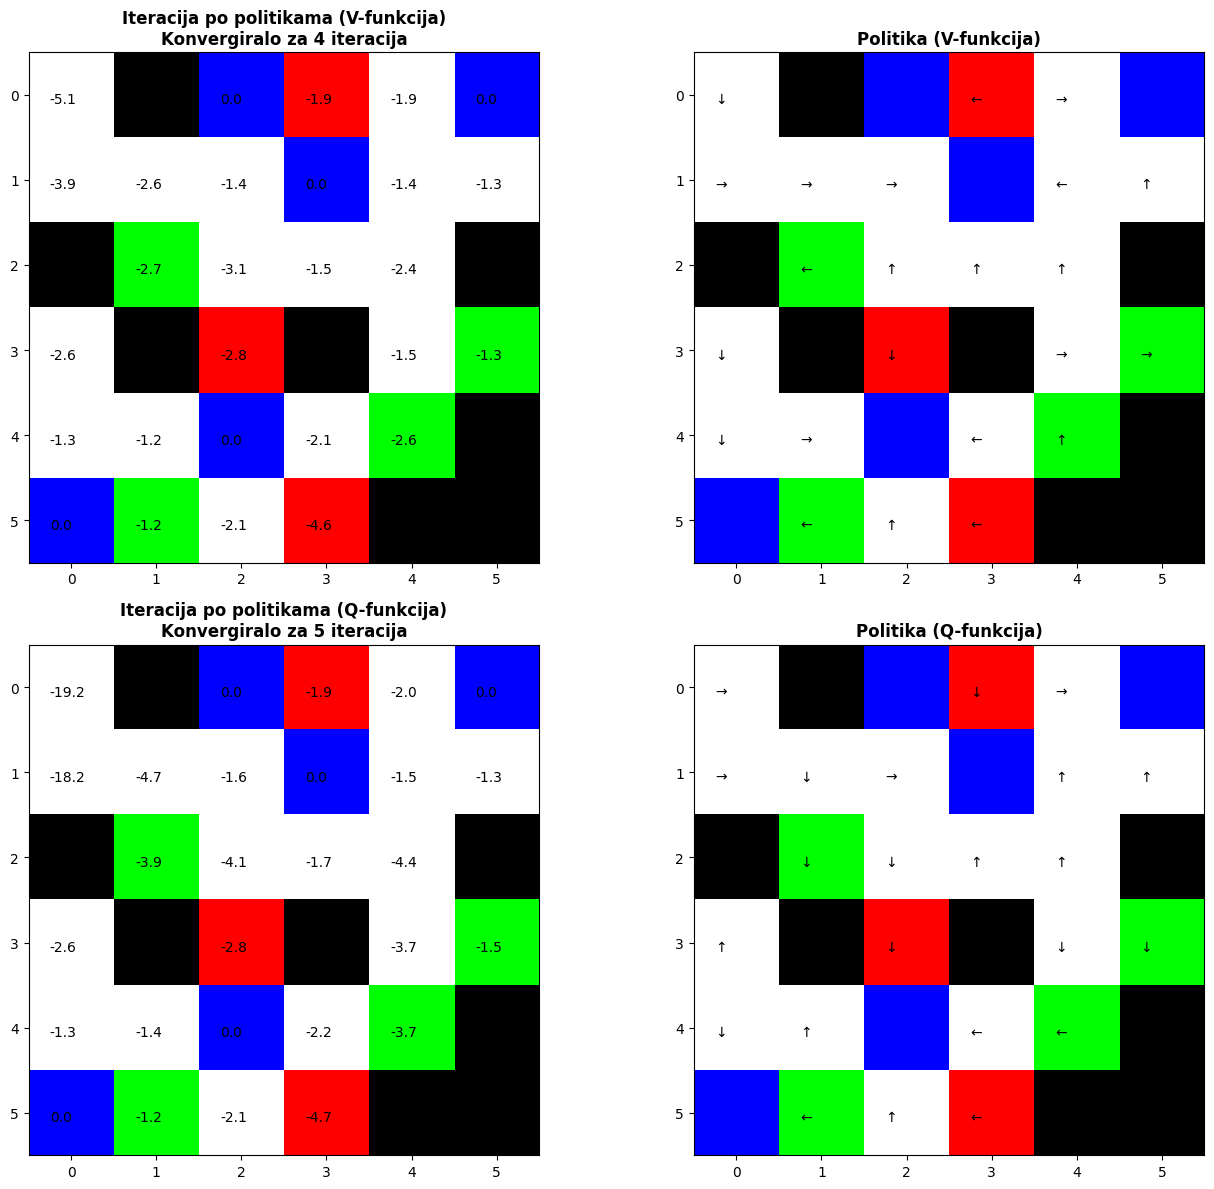

In [210]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Vrednosti iz V-funkcije
draw_values(env_stochastic, v_stoch_pi, ax=axes[0, 0])
axes[0, 0].set_title(f'Iteracija po politikama (V-funkcija)\nKonvergiralo za {k_stoch_pi_v} iteracija', fontsize=12, fontweight='bold')

# Politika iz V-funkcije
draw_policy(env_stochastic, pi_stoch_v, ax=axes[0, 1])
axes[0, 1].set_title('Politika (V-funkcija)', fontsize=12, fontweight='bold')

# Vrednosti iz Q-funkcije
draw_values(env_stochastic, v_stoch_pi_from_q, ax=axes[1, 0])
axes[1, 0].set_title(f'Iteracija po politikama (Q-funkcija)\nKonvergiralo za {k_stoch_pi_q} iteracija', fontsize=12, fontweight='bold')

# Politika iz Q-funkcije
draw_policy(env_stochastic, pi_stoch_q, ax=axes[1, 1])
axes[1, 1].set_title('Politika (Q-funkcija)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

**Komentar:** *Oba algoritma uspešno pronalaze optimalnu politiku, ali V-iteracija konvergira brže. Q-iteracija je korisna kada je potrebno direktno raditi sa akcijama i stohastičnim tranzicijama. Vizualizacije potvrđuju da agent uči efikasno ponašanje u lavirintu.*